# Tinker+ (2017) SMHM-relations

Here we will fit the Tinker+ (2017) stellar mass-to-halo mass transformations. We use a digitized version of Figure 10 from Tinker+, fitting to the mean halo mass per stellar mass curve having $\log M_* = 0.18$ dex. (_This is the green dashed line in the left side of Figure 10._)

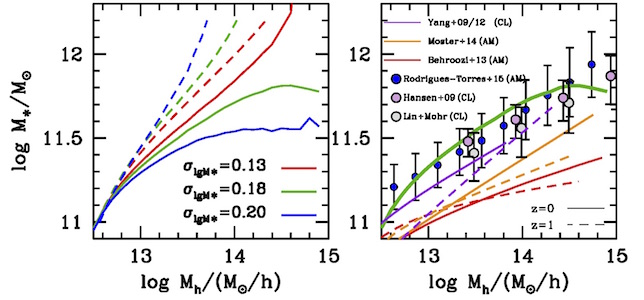

# 1. Fit to the digitized version of Tinker+ (2017) Figure 10

In [3]:
##Set up matplotlib for display in the browser:
%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=250)

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table,Column

### 1.1 Read in the digitized data 
The digitized version of Figure 10 (above) was created using [WebPlotDigitizer](http://arohatgi.info/WebPlotDigitizer/).

In [4]:
# Read the digitized version from CSV [made using http://arohatgi.info/WebPlotDigitizer/]
tinker_data = ascii.read('tinker2017-SMHMrelation.csv',data_start=0,
                         names=['log_mhalo','log_mstar'])
mhalo = tinker_data['log_mhalo']
mstar = tinker_data['log_mstar']

We're going to compare this to the results from Shan+ (2017) and Velander+ (2014). The following creates the relationships from those works.

In [5]:
#Shan+ (2017)
from pyND.gal.halos import smhm_shan
shan_mstar = np.arange(10.,12.5,0.05)
shan_mhalo = smhm_shan(shan_mstar,0.5)

#Velander+ (2014): red galaxies
beta=1.36
logM0=np.log10(1.43e13)
logMfiducial=11.3
velander_mhalo = logM0+beta*(shan_mstar-logMfiducial)

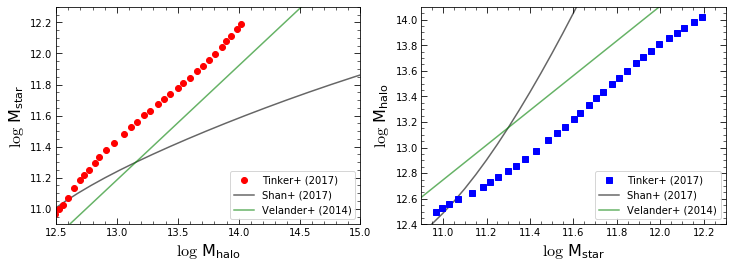

In [11]:
plt.figure(figsize=(12,4));
plt.subplot(121);
plt.plot(mhalo,mstar,'ro',label='Tinker+ (2017)');
plt.plot(shan_mhalo,shan_mstar,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.plot(velander_mhalo,shan_mstar,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.xlabel(r'$\log \ M_{halo}$',fontsize=16);
plt.ylabel(r'$\log \ M_{star}$',fontsize=16);
plt.xlim(12.5,15.) ; plt.ylim(10.9,12.3); #Match Figure 10
plt.legend(loc='lower right');

plt.subplot(122);
plt.plot(mstar,mhalo,'bs',label='Tinker+ (2017)');
plt.plot(shan_mstar,shan_mhalo,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.plot(shan_mstar,velander_mhalo,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
#plt.plot(shan_mstar,velander_mhalo-0.25,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}$',fontsize=16);
#plt.xlim(10.5,12.3) ; plt.ylim(11.4,14.1);
plt.xlim(10.9,12.3) ; plt.ylim(12.4,14.1);
plt.legend(loc='lower right');

### 1.2 Fit the distribution as a function of stellar mass

Now we fit the Tinker results with a function to apply to objects above stellar masses M$_{star} \geq 10^{11}$ M$_\odot$.

In [50]:
from astropy.modeling import models, fitting
from pyND.abs import plotzero

fitter = fitting.LevMarLSQFitter()
linfitter = fitting.LinearLSQFitter()

In [60]:
cheb1 = models.Chebyshev1D(degree=5)
cheb_fit = linfitter(cheb1, mstar, mhalo)

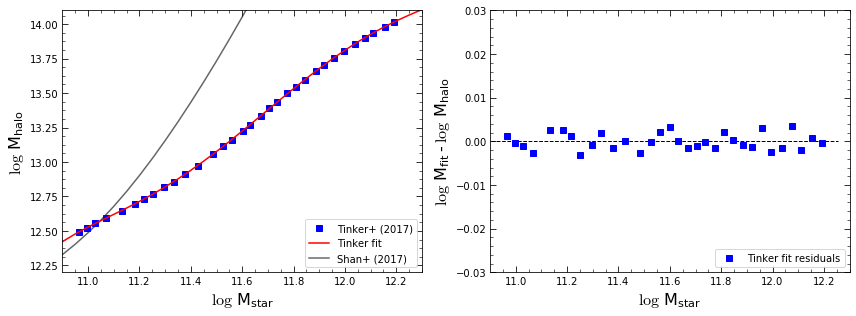

In [95]:
plt.figure(figsize=(12,4.5));
plt.subplot(121);
plt.plot(mstar,mhalo,'bs',label='Tinker+ (2017)');
plt.plot(shan_mstar,cheb_fit(shan_mstar),'-r',label='Tinker fit')
plt.plot(shan_mstar,shan_mhalo,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}$',fontsize=16);
plt.xlim(10.9,12.3) ; plt.ylim(12.2,14.1);
plt.legend(loc='lower right');

plt.subplot(122);
plt.plot(mstar,cheb_fit(mstar)-mhalo,'bs',label='Tinker fit residuals');
plotzero()
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{fit} - \log \ M_{halo}$',fontsize=16);
plt.xlim(10.9,12.3) ; plt.ylim(-0.03,0.03);
plt.legend(loc='lower right');
plt.tight_layout();

The fit looks quite good, with residuals <<0.01 dex. 

The next step is to extract the Chebyshev polynomial coefficients in order to allow a general fit (or else refit it each time, but that seems inefficient).

The results are stored in the `parameters` attribute:

In [69]:
cheb_fit.parameters

array([  1.32346104e+01,   7.91871210e-01,   3.15295503e-02,
        -3.61008162e-02,  -1.00772612e-02,   4.77010259e-03])

`Chebyshev1D(5, c0=13.23461038377845, c1=0.7918712099427608, c2=0.0315295503158018, c3=-0.036100816161890176, c4=-0.01007726117299734, c5=0.004770102585828059)`

When defining this in future code, we can set the parameters of a 5th-order Chebyshev model:

In [87]:
smhm_fit = models.Chebyshev1D(5, c0=13.23461038377845, c1=0.7918712099427608, 
                              c2=0.0315295503158018, c3=-0.036100816161890176, 
                              c4=-0.01007726117299734, c5=0.004770102585828059,
                             domain=[10.96636,12.19191])

To test the new fits, let's replot the data from above:

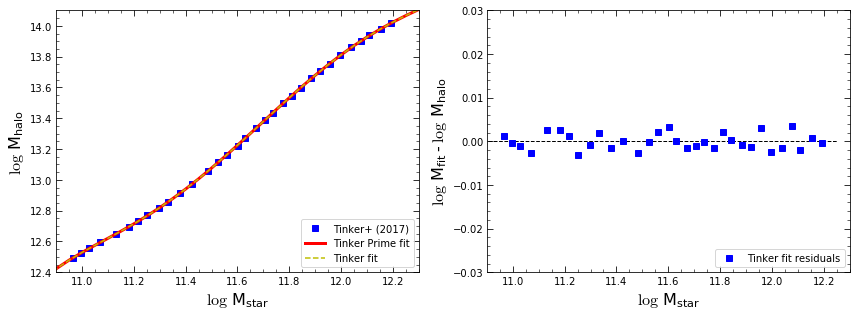

In [91]:
plt.figure(figsize=(12,4.5));
plt.subplot(121);
plt.plot(mstar,mhalo,'bs',label='Tinker+ (2017)');
plt.plot(shan_mstar,smhm_fit(shan_mstar),'-',color='red',label='Tinker Prime fit',linewidth=3);
plt.plot(shan_mstar,cheb_fit(shan_mstar),'--',color='y',label='Tinker fit');
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}$',fontsize=16);
plt.xlim(10.9,12.3) ; plt.ylim(12.4,14.1);
plt.legend(loc='lower right');

plt.subplot(122);
plt.plot(mstar,smhm_fit(mstar)-mhalo,'bs',label='Tinker fit residuals');
plotzero()
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{fit} - \log \ M_{halo}$',fontsize=16);
plt.xlim(10.9,12.3) ; plt.ylim(-0.03,0.03);
plt.legend(loc='lower right');
plt.tight_layout();

The results of the code can be found in `pyND.gal.halos.smhm_tinker`.